In [65]:
# import sys
import os
import logging
import pathlib
# import glob
# from typing import List
import numpy as np
import re
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# from dateutil import parser
# from datetime import datetime
from urllib.parse import urlparse
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl
import mlflow
import mlflow.pytorch

import matplotlib.pyplot as plt
from flexitext import flexitext

In [71]:
%load_ext autoreload
%autoreload 2

from helper_functions import epa_taiwan_data_pipeline, engine, utils, data_pipeline, visualization
from models import lstnet_gokul, lstnet_laigoukun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Set the random seed to 420
pl.seed_everything(420)

device = "cpu"
# device = "cuda" if torch.cuda.is_available else "cpu"
# device

Global seed set to 420


In [17]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
saved_model_dir = root_dir / "models"

# Data Loading and Preprocessing

- Import the data
- Feature engineering
- Turn the data into tensor

## Import the data

In [47]:
year = 2018
site_name = "Banqiao"
columns = ["SiteEngName","PM2.5","AMB_TEMP","CH4",'CO',"NMHC","read_time"]

# import data
pm25_df = epa_taiwan_data_pipeline.import_epa_data(site_name=site_name, year=year)[columns]

# basic preprocessing
pm25_df = data_pipeline.standardize_df(pm25_df, dt_col_name='read_time')

## Feature engineering

In [48]:
train_split = 0.6
history_len = 256

In [49]:
train_data = pm25_df.iloc[:int(len(pm25_df)*train_split),:]
print(f"All data length:{len(pm25_df)} \nTrain data length:{len(train_data)}")
train_data.tail(2)

All data length:8760 
Train data length:5256


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
399305,Banqiao,8.0,30.2,1.8,0.30,0.08,2018-08-07 22:00:00
399381,Banqiao,9.0,29.9,1.8,0.23,0.06,2018-08-07 23:00:00


In [50]:
test_data = pm25_df.iloc[int(len(pm25_df)*train_split):,:]
print(f"All data length:{len(pm25_df)} \nTest data length:{len(test_data)}")
test_data.tail(2)

All data length:8760 
Test data length:3504


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
665609,Banqiao,4.0,16.6,1.9,0.34,0.08,2018-12-31 22:00:00
665685,Banqiao,4.0,16.6,1.9,0.31,0.07,2018-12-31 23:00:00


# Experimentation

- Prepare different scenarios
    - [x] number of epochs --> [50, 100, 200]
    - [x] lookback periods --> [24, 24x2, 24x7, 24x30] (history_len)
    - [x] batch size --> [16, 64, 128]
    - [x] loss function --> [MSE (nn.MSELoss()), MAE (nn.L1Loss()), Huber Loss (nn.SmoothL1Loss())]
- Log the experiment
- Monitor the result with MLFlow or ~~tensorboard~~

In [12]:
lr = 1e-3
weight_decay = 0.01

epochs = [10, 20, 50]
lookback_periods = [24//2, 24, 24*2, 24*7]
batch_sizes = [16, 32, 64]
# loss_functions = [nn.MSELoss(), nn.SmoothL1Loss()]

## Manual

In [10]:
# experiment_dir = root_dir / "experiment"
# if not os.path.exists(experiment_dir):
#     os.mkdir(experiment_dir)
    
# manual_exp_dir = experiment_dir / "manual"
# if not os.path.exists(manual_exp_dir):
#     os.mkdir(manual_exp_dir)

# timestamp = datetime.now().strftime("%Y_%m_%d") # returns current date in YYYY-MM-DD format
# current_manual_exp_dir = manual_exp_dir / str(timestamp)
# if not os.path.exists(current_manual_exp_dir):
#     os.mkdir(current_manual_exp_dir)

# # lstnet_gokul_exp_dir = current_manual_exp_dir / "LSTNET_UNI_GOKUL"
# # if not os.path.exists(lstnet_gokul_exp_dir):
# #     os.mkdir(lstnet_gokul_exp_dir)

In [11]:
# train_loss_tracker_name = "train_epoch_loss.txt"
# test_loss_tracker_name = "test_epoch_loss.txt"

# combinations = [(epoch, batch_size, lookback) for epoch in epochs for batch_size in batch_sizes for lookback in lookback_periods]

# for epoch, batch_size, lookback in combinations:
# # for epoch, batch_size, lookback in [(2,4,12)]:
#     # train data preprocessing
#     train_data, normalized_column_names = epa_taiwan_data_pipeline.min_max_df_norm(train_data)

#     train_dataset = epa_taiwan_data_pipeline.AqiDataset(
#         train_data,
#         history_len=history_len,
#         col_names=[normalized_column_names[0]], 
#         device=device)

#     train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

#     # test data preprocessing
#     test_data, _ = epa_taiwan_data_pipeline.min_max_df_norm(test_data)

#     test_dataset = epa_taiwan_data_pipeline.AqiDataset(
#         test_data,
#         history_len=history_len,
#         col_names=[normalized_column_names[0]], 
#         device=device)
    
#     test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

#     # model preparation
#     model_name = f"{epoch}E_{lookback}W_{batch_size}B"
#     model = lstnet_gokul.LSTNet(
#         ar_window_size=lookback,
#         num_features=1,
#         recc1_out_channels=64,
#         conv1_out_channels=32).to(device)
#     tracker_dir = current_manual_exp_dir / model_name
#     if not os.path.exists(tracker_dir):
#         os.mkdir(tracker_dir)

#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     # Define your training loop
#     epoch_avg_train_loss, epoch_avg_test_loss = engine.train(
#         model=model,
#         train_dataloader=train_data_loader,
#         test_dataloader=test_data_loader,
#         optimizer=optimizer,
#         loss_fn=criterion,
#         epochs=epoch,
#         device=device,
#         train_tracker_dir=str(tracker_dir / train_loss_tracker_name),
#         test_tracker_dir=str(tracker_dir / test_loss_tracker_name)
#     )

#     # with open(tracker_dir / train_loss_tracker_name, 'a+') as file:
#     #     file.write(f'{epoch_avg_train_loss}\n')
#     # with open(tracker_dir / test_loss_tracker_name, 'a+') as file:
#     #     file.write(f'{epoch_avg_test_loss}\n')

In [12]:
# tracked_files = list((current_manual_exp_dir / os.listdir(current_manual_exp_dir)[0]).glob("*.txt"))

# train_loss = pd.read_csv(tracked_files[1], delimiter = "\t", header=None)
# test_loss = pd.read_csv(tracked_files[0], delimiter = "\t", header=None)

In [13]:
# fig, ax = plt.subplots()

# train_loss.plot(ax=ax, label="training")
# test_loss.plot(ax=ax, label="testing")

## MLFlow

In [16]:
# logging.basicConfig(
#     filename='LSTNET_MLFLOW_training.log',
#     level=logging.INFO,
#     format="%(asctime)s %(levelname)s:%(message)s",
#     datefmt='%Y-%m-%d %H:%M:%S'
# )

# # experiment_name = datetime.now().strftime("%Y_%m_%d") # returns current date in YYYY-MM-DD format
# experiment_name = "test1"

# # Check if the experiment exists, and if not, create it
# if not mlflow.get_experiment_by_name(experiment_name):
#     mlflow.create_experiment(experiment_name)
# experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

# os.environ['MLFLOW_TRACKING_USERNAME'] = 'amrirasyidi'
# os.environ['MLFLOW_TRACKING_PASSWORD'] = # password

# remote_server_uri="https://dagshub.com/amrirasyidi/air_quality_forecasting.mlflow"
# mlflow.set_tracking_uri(remote_server_uri)
# tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

# for epoch, batch_size, lookback in [(1,8,12)]:
#     with mlflow.start_run(experiment_id=experiment_id) as run:
#         mlflow.log_param("Epoch",epoch)
#         mlflow.log_param("Batch Size",batch_size)
#         mlflow.log_param("Lookback Period",lookback)

#         model_name = f"LSTNET_{epoch}E_{batch_size}B_{lookback}W"
#         model = lstnet_gokul.LSTNet(
#             ar_window_size=lookback,
#             num_features=1,
#             recc1_out_channels=64,
#             conv1_out_channels=32
#         )

#         criterion = nn.MSELoss()
#         optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#         # train data preprocessing
#         train_data, normalized_column_names = epa_taiwan_data_pipeline.min_max_df_norm(train_data)

#         train_dataset = epa_taiwan_data_pipeline.AqiDataset(
#             train_data,
#             history_len=history_len,
#             col_names=[normalized_column_names[0]],
#             device=device)

#         train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

#         # test data preprocessing
#         test_data, _ = epa_taiwan_data_pipeline.min_max_df_norm(test_data)

#         test_dataset = epa_taiwan_data_pipeline.AqiDataset(
#             test_data,
#             history_len=history_len,
#             col_names=[normalized_column_names[0]], 
#             device=device)

#         test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

#         engine.train(
#             model=model,
#             model_name=model_name,
#             train_dataloader=train_data_loader,
#             test_dataloader=test_data_loader,
#             optimizer=optimizer,
#             loss_fn=criterion,
#             device=device,
#             epochs=epoch,
#             patience=3
#         )

#         # Model registry does not work with file store
#         if tracking_url_type_store != "file":
#             # Register the model
#             mlflow.pytorch.log_model(
#                 model, model_name, registered_model_name=model_name
#             )
#         else:
#             mlflow.pytorch.log_model(model, model_name)

#         # save the model
#         utils.save_model(
#             model=model,
#             target_dir="saved_models",
#             model_name=model_name + ".pth"
#             )

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\arasyidi\AppData\Roaming\Python\Python311\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'LSTNET_1E_8B_12W' already exists. Creating a new version of this model...
2023/09/04 13:09:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LSTNET_1E_8B_12W, version 2
Created version '2' of model 'LSTNET_1E_8B_12W'.


In [22]:
# # Set the experiment name
# experiment_name = datetime.now().strftime("%Y_%m_%d") # returns current date in YYYY-MM-DD format

# # Check if the experiment exists, and if not, create it
# if not mlflow.get_experiment_by_name(experiment_name):
#     mlflow.create_experiment(experiment_name)

# os.environ['MLFLOW_TRACKING_USERNAME'] = 'amrirasyidi'
# os.environ['MLFLOW_TRACKING_PASSWORD'] = 'a2c9e1ebaf6ce8285a9cced5e2c757c386254b7a'

# normalized_columns = ['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc']
# combinations = [(epoch, batch_size, lookback) for epoch in epochs for batch_size in batch_sizes for lookback in lookback_periods]

# mlflow.end_run()
# # # with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name(experiment_name).experiment_id) as run:
# # with mlflow.start_run() as run:
# #     ## For Remote server only (DAGShub)
# #     remote_server_uri="https://dagshub.com/amrirasyidi/air_quality_forecasting.mlflow"
# #     mlflow.set_tracking_uri(remote_server_uri)
# #     tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

# #     # for epoch, batch_size, lookback in combinations:
# #     for epoch, batch_size, lookback in [(2,4,12)]:
# #         # train data preprocessing
# #         train_data, normalized_column_names = epa_taiwan_data_pipeline.min_max_df_norm(train_data)

# #         train_dataset = epa_taiwan_data_pipeline.AqiDataset(
# #             train_data,
# #             history_len=history_len,
# #             col_names=[normalized_column_names[0]], 
# #             device=device)

# #         train_data_loader = DataLoader(train_dataset, batch_size=batch_size)

# #         # test data preprocessing
# #         test_data, _ = epa_taiwan_data_pipeline.min_max_df_norm(test_data)

# #         test_dataset = epa_taiwan_data_pipeline.AqiDataset(
# #             test_data,
# #             history_len=history_len,
# #             col_names=[normalized_column_names[0]], 
# #             device=device)

# #         test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

# #         # model preparation
# #         model_name = f"{epoch}E_{lookback}W_{batch_size}B"
# #         model = lstnet_gokul.LSTNet(
# #             ar_window_size=lookback,
# #             num_features=1,
# #             recc1_out_channels=64,
# #             conv1_out_channels=32).to(device)

# #         criterion = nn.MSELoss()
# #         optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# #         # Define your training loop
# #         epoch_avg_train_loss, epoch_avg_test_loss = engine.train(
# #             model=model,
# #             train_dataloader=train_data_loader,
# #             test_dataloader=test_data_loader,
# #             optimizer=optimizer,
# #             loss_fn=criterion,
# #             epochs=epoch,
# #             device=device,
# #             train_tracker_dir=None,
# #             test_tracker_dir=None
# #         )

# #         # print("LSTNET model (learning_rate={:f}, batch_size={:f}):".format(lr, batch_size))

# #         # Log hyperparameters
# #         mlflow.log_param("epoch",epoch)
# #         mlflow.log_param("batch_size",batch_size)
# #         mlflow.log_param("lookback",lookback)

# #         # Log metrics during training
# #         mlflow.log_metrics(
# #             {
# #                 "train_loss": epoch_avg_train_loss[0],
# #                 "test_loss": epoch_avg_test_loss[0]
# #             },
# #             step=epoch
# #         )

# #         # # Log additional artifacts
# #         # mlflow.log_artifact("path/to/your/training_plots.png")

# #         # # Model registry does not work with file store
# #         # if tracking_url_type_store != "file":
# #         #     # Register the model
# #         #     # There are other ways to use the Model Registry, which depends on the use case,
# #         #     # please refer to the doc for more information:
# #         #     # https://mlflow.org/docs/latest/model-registry.html#api-workflow
# #         #     mlflow.pytorch.log_model(
# #         #         model, model_name, registered_model_name=model_name
# #         #     )
# #         # else:
# #         #     mlflow.pytorch.log_model(model, model_name)

# Inferencing

- Load the best model
- Prepare the test data
- Save the result

In [43]:
# Setup the best model filepath
model_name = "LSTNET_50E_32B_168W.pth"
best_model_path = saved_model_dir / model_name

# Extract relevant parts using a single regex pattern
match = re.match(r'[^_]+_(\d+)E_(\d+)B_(\d+)W\.pth', model_name)

# Extract values from the matched groups and convert them to integers
epoch, batch_size, lookback_period = map(int, match.groups())

In [44]:
# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = lstnet_gokul.LSTNet(
    ar_window_size=lookback_period,
    num_features=1,
    recc1_out_channels=64,
    conv1_out_channels=32
)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [57]:
inference_data, normalized_column_names = data_pipeline.df_norm(test_data, [test_data.columns[1]])
inf_min_pm, inf_max_pm = inference_data["pm2.5"].min(), inference_data["pm2.5"].max()

inf_dataset = epa_taiwan_data_pipeline.AqiDataset(
    inference_data, 
    history_len=lookback_period,
    col_names=[normalized_column_names[0]],
    device=device
)
inf_data_loader = DataLoader(inf_dataset, batch_size=batch_size, shuffle=False)

In [64]:
for i, batch in tqdm(enumerate(inf_data_loader, start=1),leave=False, total=len(inf_data_loader)):
    X, Y = batch
    Y_pred = best_model(X).detach().numpy()
    if i == 1:
        predictions = Y_pred
    else:
        predictions = np.concatenate((predictions, Y_pred), axis=0)

predictions = predictions * (inf_max_pm - inf_min_pm) + inf_min_pm

columns = ['pm2.5']
predictions = pd.DataFrame(predictions, columns=columns)
predictions['read_time'] = test_data.reset_index()['read_time']
print(predictions.shape)
predictions.head()

  0%|          | 0/105 [00:00<?, ?it/s]

(3336, 2)


,pm2.5,read_time
0,8.053886,2018-08-08 00:00:00
1,8.540859,2018-08-08 01:00:00
2,9.796215,2018-08-08 02:00:00
3,12.407160,2018-08-08 03:00:00
4,12.381547,2018-08-08 04:00:00


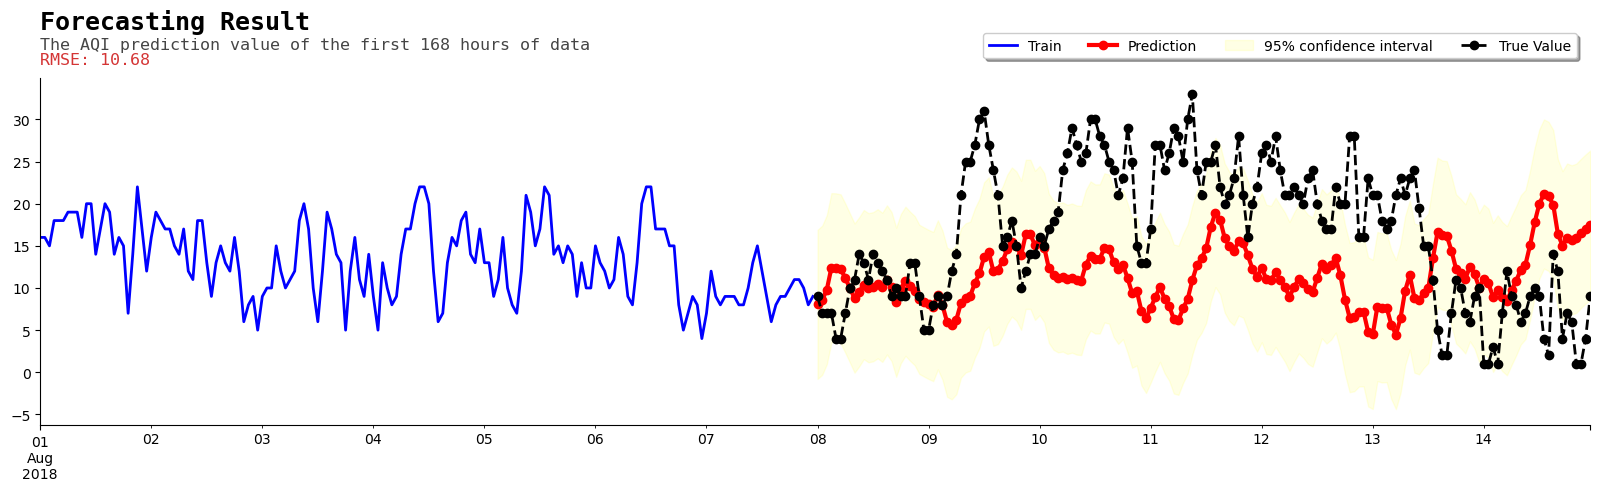

In [72]:
visualization.plot_prediction(
    lookback_period,
    train_data,
    inference_data,
    predictions
)

# Transfer Learning to KLHK Data

In [80]:
best_model

LSTNet(
  (conv1): Conv2d(1, 32, kernel_size=(7, 1), stride=(1, 1))
  (recc1): GRU(32, 64, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=176, out_features=1, bias=True)
  (ar): Linear(in_features=168, out_features=1, bias=True)
)

In [76]:
for param in best_model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 6.7513e-13],
          [ 1.8718e-12],
          [ 3.1154e-13],
          [ 1.0949e-13],
          [ 4.6671e-14],
          [ 2.0739e-11],
          [ 6.7563e-14]]],


        [[[ 1.6671e-15],
          [ 1.8565e-16],
          [-1.4730e-15],
          [ 6.5086e-15],
          [ 1.1403e-15],
          [-2.8165e-16],
          [ 1.4189e-15]]],


        [[[ 5.9034e-29],
          [ 8.1527e-29],
          [ 5.5895e-29],
          [ 2.9336e-29],
          [ 5.3240e-29],
          [ 5.2557e-29],
          [ 7.1767e-29]]],


        [[[-3.8376e-09],
          [-2.8131e-09],
          [-7.0539e-09],
          [-5.3012e-09],
          [-3.8825e-09],
          [-1.3233e-08],
          [-1.2525e-08]]],


        [[[ 4.7483e-09],
          [ 7.8410e-08],
          [ 1.9381e-08],
          [ 1.7117e-08],
          [ 9.0963e-08],
          [ 1.5748e-08],
          [ 1.8551e-08]]],


        [[[ 3.5056e-06],
          [ 3.5106e-06],
          [ 4.4350e-06],
        